In [1]:
import xml.etree.ElementTree as ET
import numpy as np
from utils_bezier import bezier_surface
import matplotlib.pyplot as plt
from typing import List, Optional

tree = ET.parse("/Users/jensencl/Documents/Shape3D_files/test.s3dx")
shape3D_node = tree.getroot()

In [2]:
board_node = shape3D_node.find("Board")
# bottom_node = board_node.find("curveDefSide0")
# deck_node = board_node.find("curveDefSide4")
# outline_node = board_node.find("curveDefTop2")

In [3]:
board_node.findall("Couples_1/Bezier3d/Control_points/Polygone3d/Point3d")

[<Element 'Point3d' at 0x11eeb1300>,
 <Element 'Point3d' at 0x11eeb14e0>,
 <Element 'Point3d' at 0x11eeb16c0>,
 <Element 'Point3d' at 0x11eeb18a0>,
 <Element 'Point3d' at 0x11eeb1a80>]

In [4]:
def read_bezier_spline_from_node(parent):

    ctrl_point_nodes = parent.findall("Bezier3d/Control_points/Polygone3d/Point3d")
    tangent1_nodes = parent.findall("Bezier3d/Tangents_1/Polygone3d/Point3d")
    tangent2_nodes = parent.findall("Bezier3d/Tangents_2/Polygone3d/Point3d")

    spline = []

    # 
    for cp, t1, t2 in zip(ctrl_point_nodes, tangent1_nodes, tangent2_nodes):
        cx = float(cp.find("x").text)
        cy = float(cp.find("y").text)
        cz = float(cp.find("z").text)
        t1x = float(t1.find("x").text)
        t1y = float(t1.find("y").text)
        t1z = float(t1.find("z").text)
        t2x = float(t2.find("x").text)
        t2y = float(t2.find("y").text)
        t2z = float(t2.find("z").text)
        # print("c", cx, cy, cz, "t1", t1x, t1y, t1z, "t2", t2x, t2y, t2z)
        bezier_curve = [[t1x, cx, t2x], [t1y, cy, t2y], [t1z, cz, t2z]]
        spline.append(bezier_curve)
    
    return spline

slices = []

for i in range(100):
    slice_node = board_node.find(f"Couples_{i}")

    if slice_node is None:
        break
    
    spline = read_bezier_spline_from_node(slice_node)
    slices.append(spline)


In [5]:
slices = slices[:2]

# Control points
# x = np.array([bc[0] for s in slices for bc in s])
# y = np.array([bc[1] for s in slices for bc in s])
# z = np.array([bc[2] for s in slices for bc in s])

x, y, z = [], [], []
for s in slices:
    slice_x, slice_y, slice_z = [], [], []
    for bc in s:
        slice_x.extend(bc[0])
        slice_y.extend(bc[1])
        slice_z.extend(bc[2])
    x.append(slice_x)
    y.append(slice_y)
    z.append(slice_z)
x = np.array(x)
y = np.array(y)
z = np.array(z)

# Number of cells for each direction
uCELLS = 120
wCELLS = 100

xBezier, yBezier, zBezier = bezier_surface(x, y, z, uCELLS, wCELLS)

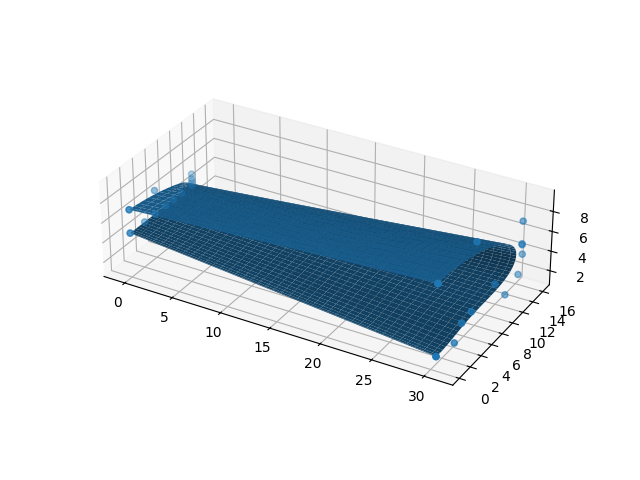

In [6]:
%matplotlib widget

# Bezier surface (NOTE: only slices are used here. Stringer and outline is not)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(xBezier, yBezier, zBezier)
ax.scatter(x, y, z, edgecolors='face')
ax.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

# NURBS-Python / geomdl

In [7]:
import sys
sys.path.append('../')

In [8]:
from cadcore.bezier_curve import BezierCurve
from cadcore.bezier_slice import BezierSlice
from cadcore.bezier_board import BezierBoard
from cadcore.bezier_control_point_interpolation_surface_model import BezierControlPointInterpolationSurfaceModel

In [9]:
import xml.etree.ElementTree as ET
from typing import List, Any
# import numpy as np

class S3dxReader():
    XY = 0
    XZ = 1
    YZ = 2

    def read_bezier_spline_from_node(self, parent: ET.Element, which_plane: int):
        ctrl_point_nodes = parent.findall("Bezier3d/Control_points/Polygone3d/Point3d")
        tangent1_nodes = parent.findall("Bezier3d/Tangents_1/Polygone3d/Point3d")
        tangent2_nodes = parent.findall("Bezier3d/Tangents_2/Polygone3d/Point3d")

        spline = []

        # 
        for cp, t1, t2 in zip(ctrl_point_nodes, tangent1_nodes, tangent2_nodes):
            cx = float(cp.find("x").text)
            cy = float(cp.find("y").text)
            cz = float(cp.find("z").text)
            t1x = float(t1.find("x").text)
            t1y = float(t1.find("y").text)
            t1z = float(t1.find("z").text)
            t2x = float(t2.find("x").text)
            t2y = float(t2.find("y").text)
            t2z = float(t2.find("z").text)
            # print("c", cx, cy, cz, "t1", t1x, t1y, t1z, "t2", t2x, t2y, t2z)

            if which_plane == S3dxReader.XY:
                p1x = cx
                p1y = cy
                p2x = t1x
                p2y = t1y
                p3x = t2x
                p3y = t2y
                pos = cz
            elif which_plane == S3dxReader.XZ:
                p1x = cx
                p1y = cz
                p2x = t1x
                p2y = t1z
                p3x = t2x
                p3y = t2z
                pos = cy
            elif which_plane == S3dxReader.YZ:
                p1x = cy
                p1y = cz
                p2x = t1y
                p2y = t1z
                p3x = t2y
                p3y = t2z
                pos = cx

            bezier = [[p1x, p1y], [p2x, p2y], [p3x, p3y]]
            spline.append(bezier)
        
        return spline, pos

    def extract_curves(self, spline: List[Any]):
        curves = []
        for bezier_idx in range(len(spline) - 1):
            ctrl_pts = [spline[bezier_idx][0], spline[bezier_idx][2], spline[bezier_idx+1][1], spline[bezier_idx+1][0]] 
            crv = BezierCurve(ctrl_pts)
            curves.append(crv)
        return curves

    def load_file(self, filename):
        tree = ET.parse(filename)
        shape3D_node = tree.getroot()
        board_node = shape3D_node.find("Board")

        # Read slices
        slices = []
        slice_x_pos = []
        for i in range(100):
            slice_node = board_node.find(f"Couples_{i}")

            if slice_node is None:
                break
            
            spline, x_pos = self.read_bezier_spline_from_node(slice_node, S3dxReader.YZ)
            # Subtract however high the slice is above zero
            height = spline[0][0][1]
            spline = [[[p[0], p[1] - height] for p in bezier] for bezier in spline]
            slices.append((spline, x_pos))

        # Read stringer and outline
        deck_node = board_node.find("curveDefSide4/BezierDef")
        deck, deck_pos = self.read_bezier_spline_from_node(deck_node, S3dxReader.XZ)
        bottom_node = board_node.find("curveDefSide0/BezierDef")
        bottom, bottom_pos = self.read_bezier_spline_from_node(bottom_node, S3dxReader.XZ)
        outline_node = board_node.find("curveDefTop2/BezierDef")
        outline, outline_pos = self.read_bezier_spline_from_node(outline_node, S3dxReader.XY)

        # Convert to internal representations
        bezier_slices: List[BezierSlice] = []
        for s, pos in slices:
            bezier_curves = self.extract_curves(s)
            bezier_slices.append(BezierSlice(bezier_curves, pos))

        bezier_deck = BezierSlice(self.extract_curves(deck), deck_pos)
        bezier_bottom = BezierSlice(self.extract_curves(bottom), bottom_pos)
        bezier_outline = BezierSlice(self.extract_curves(outline), outline_pos)
        
        board: BezierBoard = BezierBoard(bezier_slices, bezier_deck, bezier_bottom, bezier_outline)

        return board        


reader: S3dxReader = S3dxReader()
board: BezierBoard = reader.load_file("/Users/jensencl/Documents/Shape3D_files/test.s3dx")
# board: BezierBoard = reader.load_file("/Users/jensencl/Documents/Shape3D_files/Klokhouse_Noseless.s3dx")


In [10]:
# from geomdl import multi
# from geomdl.visualization import VisPlotly

# curves = [[c.curve for c in bs.curves] for bs in board.bezier_slices[:2]]

# # Add interpolated slices
# interpolated_slice = board.get_interpolated_slice(5)
# curves.append([c.curve for c in interpolated_slice.curves])
# interpolated_slice = board.get_interpolated_slice(15)
# curves.append([c.curve for c in interpolated_slice.curves])
# interpolated_slice = board.get_interpolated_slice(25)
# curves.append([c.curve for c in interpolated_slice.curves])

# # Create a curve container
# mcrv = multi.CurveContainer(*curves)

# # Draw the control point polygon and the evaluated curve
# vis_comp1 = VisPlotly.VisCurve2D()
# mcrv.vis = vis_comp1
# mcrv.render()

### View slices

In [11]:
from geomdl import multi
from geomdl.visualization import VisPlotly

curves = [[c.curve for c in bs.curves] for bs in board.bezier_slices[1:2]]

# Create a curve container
mcrv = multi.CurveContainer(*curves)

# Draw the control point polygon and the evaluated curve
vis_comp1 = VisPlotly.VisCurve2D()
mcrv.vis = vis_comp1
mcrv.render()

### View stringer and outline

In [12]:
from geomdl import multi
from geomdl.visualization import VisPlotly

# Create a B-Spline curve instance (Bezier Curve)
curves = [
    [c.curve for c in board.bezier_deck.curves],
    [c.curve for c in board.bezier_bottom.curves],
    [c.curve for c in board.bezier_outline.curves]
]

# Create a curve container
mcrv = multi.CurveContainer(*curves)

# Draw the control point polygon and the evaluated curve
vis_comp1 = VisPlotly.VisCurve2D()
mcrv.vis = vis_comp1
mcrv.render()

### Interpolate

In [13]:
import numpy as np
import plotly.express as px

from cadcore.bezier_curve import DEG_TO_RAD

x = board.bezier_slices[1].position
# x = x/2

surface_model = BezierControlPointInterpolationSurfaceModel()

# Get surface points
points = []
for s in np.linspace(0, 1, 150):
    points.append(surface_model.get_point_at(board, x, s))

# Find apex
APEX_DEFINITION_ANGLE = 90
interpolated_slice = board.get_interpolated_slice(x)
s_for_apex = interpolated_slice.get_s_by_normal_reverse(APEX_DEFINITION_ANGLE * DEG_TO_RAD)
_, apex_x, apex_y = surface_model.get_point_at(board, x, s_for_apex)
# apex_x, apex_y = interpolated_slice.get_point_at_s(s_for_apex)
# apex_y += board.get_rocker_at_pos(x)

X = [p[1] for p in points]
Y = [p[2] for p in points]

fig = px.scatter(x=X, y=Y)
fig.add_scatter(x=[apex_x], y=[apex_y])

In [14]:
from geomdl import fitting

min_x = board.bezier_slices[0].position
max_x = board.bezier_slices[1].position

APEX_DEFINITION_ANGLE = 90

apex_points = []

for x in np.linspace(min_x, max_x, 15):
    # Find apex
    interpolated_slice = board.get_interpolated_slice(x)
    s_for_apex = interpolated_slice.get_s_by_normal_reverse(APEX_DEFINITION_ANGLE * DEG_TO_RAD)
    p = surface_model.get_point_at(board, x, s_for_apex)
    apex_points.append(p)

# Do global curve interpolation - NOTE: This is a B-spline curve (not Bezier curve)
curve = fitting.interpolate_curve(apex_points, degree=3)
print(curve.degree)

curve.vis = VisPlotly.VisCurve3D()
curve.render()


3


In [15]:
# import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import numpy as np

surface_model = BezierControlPointInterpolationSurfaceModel()

board_length = 190
# board_length = 154
X = np.linspace(1, board_length, 200)
S = np.linspace(0, 1, 50)
x, y, z = np.vectorize(lambda x, s: surface_model.get_point_at(board, x, s))(X[:,None], S[None,:])

In [16]:
trace = go.Surface(x=x, y=y, z=z, showscale=False)
line = go.Scatter3d(x=[p[0] for p in curve.evalpts], y=[p[1] for p in curve.evalpts], z=[p[2] for p in curve.evalpts], mode='lines', line_color="green")
layout = go.Layout(scene=dict(aspectmode='data'))
fig = go.Figure(data=[trace, line], layout=layout)
pio.show(fig)